## Can you classify cards?
#### We expect you to use card images with their labels to classify unseen test images. You have to write a dataloader to read images from the folder 'cards/', write a CNN class, a loss function, a training loop, and check your test accuracy. 

In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import imageio as Image
from torchvision.utils import make_grid
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader

# **final accuracy is 87% at the end of the file**

### Nothing to change here (This cell downloads and unzips the data in the folder 'cards/'). 

In [ ]:
!wget https://www.dropbox.com/s/gxcflnuuq0a64wx/cards.zip

!unzip cards.zip

!ls

### Dataloader
#####  Training and testing data sets are given in the folder 'cards/'. The training data is given as a folder of jpg images and a csv file that contain the class names associated with every image file. The testing data is also given in the same way. The class names can be turned into integer labels using the python dictionary below. 

In [3]:
C = 53  # number of classes
class_names = ['ace of spades', 'seven of clubs', 'jack of clubs', 'two of clubs', 'queen of hearts', 
               'two of hearts', 'four of diamonds', 'queen of clubs', 'ten of spades', 'eight of diamonds', 
               'three of clubs', 'eight of hearts', 'three of diamonds', 'five of hearts', 'six of clubs', 
               'ten of diamonds', 'nine of clubs', 'ten of hearts', 'six of diamonds', 'king of diamonds', 
               'nine of hearts', 'eight of clubs', 'seven of hearts', 'five of spades', 'five of diamonds', 
               'four of hearts', 'queen of spades', 'four of spades', 'king of hearts', 'jack of spades', 
               'seven of diamonds', 'three of spades', 'jack of diamonds', 'six of spades', 'ace of hearts', 
               'king of clubs', 'nine of diamonds', 'ace of diamonds', 'eight of spades', 'nine of spades', 
               'queen of diamonds', 'jack of hearts', 'joker', 'two of diamonds', 'ten of clubs', 'seven of spades', 
               'two of spades', 'five of clubs', 'ace of clubs', 'six of hearts', 'king of spades', 'four of clubs', 
               'three of hearts']
names_to_labels = dict(zip(class_names, list(range(C))))

In [4]:
# to understand the csv file 
import pandas as pd 

df = pd.read_csv("/content/cards/cards_train.csv")
#print the to get the label of data 
df.head()

,image_name,class_name
0,1.jpg,three of hearts
1,2.jpg,three of hearts
2,3.jpg,three of hearts
3,4.jpg,three of hearts
4,5.jpg,three of hearts


In [5]:
import imageio as iio

class MyDataset(Dataset):
  def __init__(self, im_fol, csv_file, trans = None):
    super().__init__()
    df = pd.read_csv(csv_file)
    self.im_list = df["image_name"].to_list()
    self.labels = df["class_name"].to_list()
    self.im_fol = im_fol
    self.trans = trans

  def __len__(self):
    return len(self.labels)

  def __getitem__(self,idx):
    im = iio.imread(f"{self.im_fol}{self.im_list[idx]}")
    im = np.array(im)
    if self.trans:
      im = self.trans(im)

    label = self.labels[idx]
    label = names_to_labels[label] #Map class name to label
    return im, label


Write dataloaders that return images and labels for both the testing and training datasets. Use the transform below to resize the images to 56x56.

In [6]:
## ADD CODE HERE
trans = transforms.Compose([transforms.ToTensor(),transforms.Resize([56,56])])
dataset = MyDataset("/content/cards/train_cards/","/content/cards/cards_train.csv", trans = trans )

train_loader = DataLoader(dataset, batch_size=64, shuffle=True)

In [7]:
# to make sure of the sizes 
batch = next(iter(train_loader))
print(batch[0].shape)
print(batch[1].shape)

<ipython-input-5-3b70819f2fc7>:16: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im = iio.imread(f"{self.im_fol}{self.im_list[idx]}")
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to

torch.Size([64, 3, 56, 56])
torch.Size([64])


#### Visualize the data
##### Get a batch from the dataloader, show its images, and print their corresponding labels and/or names

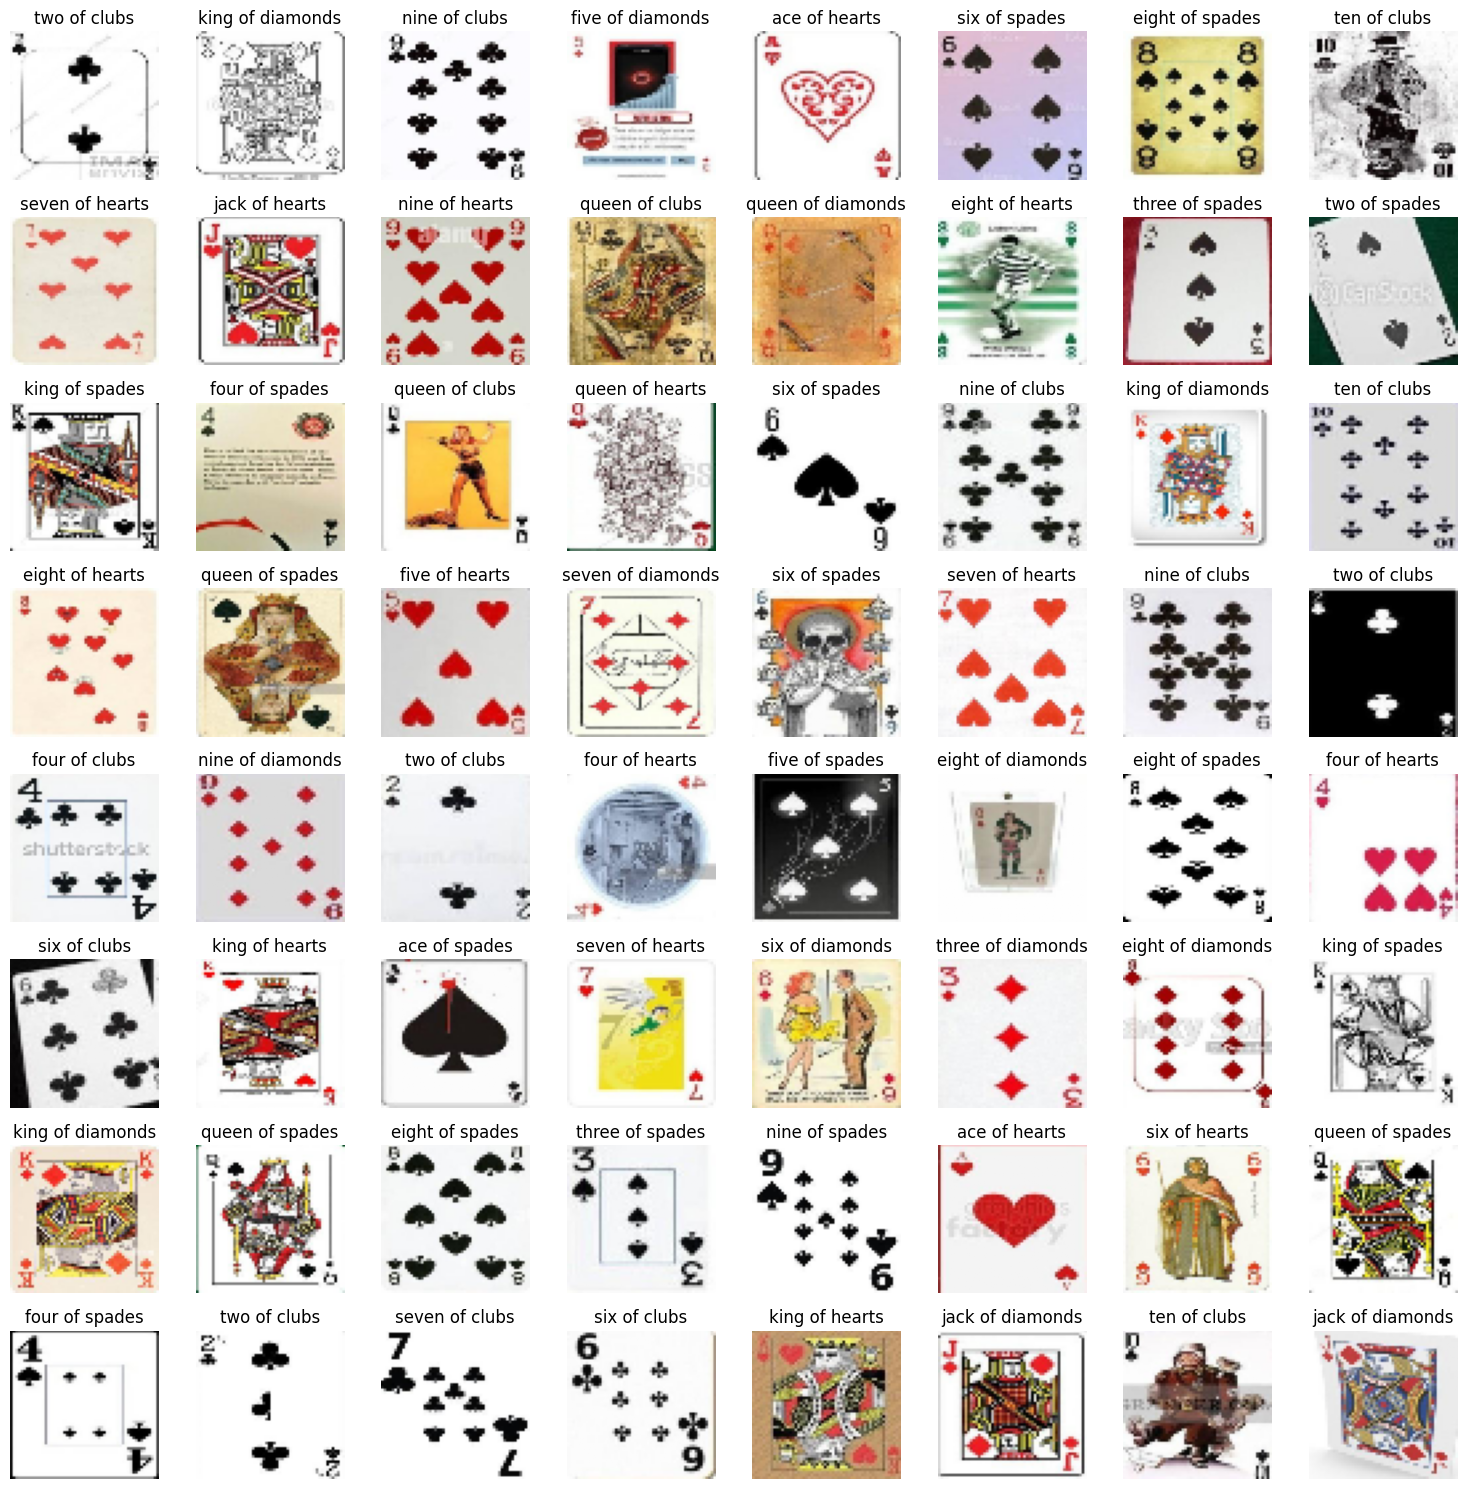

In [8]:
fig, axs = plt.subplots(8, 8, figsize=(15, 15))
for i in range(64):
    image = batch[0][i].permute(1, 2, 0) 
    label = batch[1][i].item()
    class_name = class_names[label] 
    a = i // 8
    b = i % 8
    axs[a, b].imshow(image)
    axs[a, b].axis('off')
    axs[a, b].set_title(class_name)
plt.tight_layout()
plt.show()

### Define a CNN
#### Generate a CNN for the classification task in the cell below. You may either use an existing network (ResNet18, VGG11, etc.) and modify it as needed, or build your own network from scratch. 

In [10]:
# ADD CODE HERE 
class myCNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 15 , 3 ,  1,1 )
    self.conv2 = nn.Conv2d(15, 30 , 3, 1,1 )
    self.conv3 = nn.Conv2d(30, 60 , 3, 1,1 )

    self.Linear1 =nn.Linear(60*7*7,300)
    self.Linear2 =nn.Linear(300,100)
    self.Linear3= nn.Linear(100,53)

  def forward(self,x):
    # 3  56, 56
    x = self.conv1(x)
    x = torch.relu(x)
    # 15, 56, 56
    x= F.max_pool2d(x, (2,2))
    # 15, 28, 28 
    x = self.conv2(x)
    x = torch.relu(x)
    # 30, 28, 28 
    x= F.max_pool2d(x, (2,2))
    # 30, 14, 14 
    x = self.conv3(x)
    x = torch.relu(x)
    # 60, 14, 14 
    x= F.max_pool2d(x, (2,2))
    # 60, 7,7 
     

    x = x.view(-1,60*7*7)
    x = self.Linear1(x)
    x =torch.relu(x)
    x = self.Linear2(x)
    x =torch.relu(x)
    x = self.Linear3(x)
    return x


## Loss 
#### Define Loss function in the following cell

In [11]:
# ADD CODE HERE 
#the loss of cnn cross entropy
def loss_fn(yhat, y):
    return F.cross_entropy(yhat, y)

### Training loop
#### Define an optimizer, write the training loop in the following cell, and plot the loss

Adjusting learning rate of group 0 to 1.0000e-01.


<ipython-input-5-3b70819f2fc7>:16: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im = iio.imread(f"{self.im_fol}{self.im_list[idx]}")


Adjusting learning rate of group 0 to 9.0000e-02.
Adjusting learning rate of group 0 to 8.1000e-02.
Adjusting learning rate of group 0 to 7.2900e-02.
Adjusting learning rate of group 0 to 6.5610e-02.
Adjusting learning rate of group 0 to 5.9049e-02.
Adjusting learning rate of group 0 to 5.3144e-02.
Adjusting learning rate of group 0 to 4.7830e-02.
Adjusting learning rate of group 0 to 4.3047e-02.
Adjusting learning rate of group 0 to 3.8742e-02.
Adjusting learning rate of group 0 to 3.4868e-02.
Adjusting learning rate of group 0 to 3.1381e-02.
Adjusting learning rate of group 0 to 2.8243e-02.
Adjusting learning rate of group 0 to 2.5419e-02.
Adjusting learning rate of group 0 to 2.2877e-02.
Adjusting learning rate of group 0 to 2.0589e-02.
Adjusting learning rate of group 0 to 1.8530e-02.
Adjusting learning rate of group 0 to 1.6677e-02.
Adjusting learning rate of group 0 to 1.5009e-02.
Adjusting learning rate of group 0 to 1.3509e-02.
Adjusting learning rate of group 0 to 1.2158e-02.


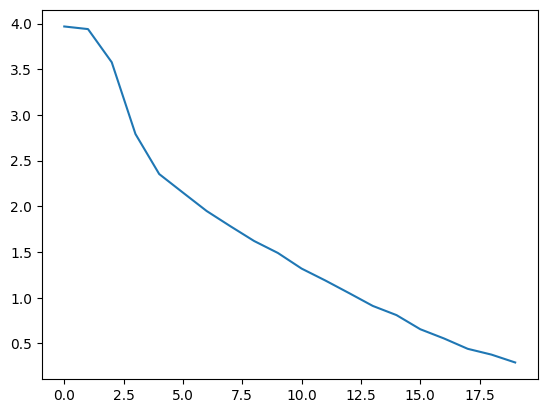

In [19]:
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = myCNN().to(device)
lr = 0.1
num_epochs = 20
ls = []
momentum = 0.5
opt = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
sch = ExponentialLR(opt, 0.9, verbose=True)
for i in range(num_epochs):
    total_loss = 0
    for batch in train_loader:
        x, y = batch[0].to(device), batch[1].to(device)
        yhat = model(x)
        loss = loss_fn(yhat, y)  # Use a different variable name for the loss tensor
        opt.zero_grad()
        loss.backward()
        opt.step()
        total_loss += loss.item()
    ls.append(total_loss / len(train_loader))
    sch.step()

plt.plot(ls)


## Check test accuracy

In [20]:
testData = MyDataset("/content/cards/test_cards/","/content/cards/cards_test.csv", trans = trans )
test_loader = DataLoader(testData, batch_size=64, shuffle=False)

In [21]:
# ADD CODE HERE
total_correct = 0
total_example=0
for batch in test_loader :
  x,y = batch[0].to(device) ,  batch[1].to(device)
  yhat = model(x)
  prediction = torch.argmax(yhat, axis = 1) #we put sofmax sepreatly becouse 
  correct_prediction= (prediction == y).sum().item()
  total_example += y.size(0)
  total_correct += correct_prediction
accuracy = total_correct/ total_example
print(f"Accuracy on the test set: {accuracy:.2%}")

<ipython-input-5-3b70819f2fc7>:16: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im = iio.imread(f"{self.im_fol}{self.im_list[idx]}")
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to

Accuracy on the test set: 67.17%


## Transfer Learning

In [22]:
from torchvision.models import resnet18
net = resnet18(pretrained = True)
net.fc = nn.Linear(in_features = 512 , out_features = 53 , bias = True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 112MB/s]


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = net.to(device)
lr = 0.01
mm = 0.5
ls = []
optimizer = optim.SGD(net.parameters(), lr = lr , momentum = mm)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer , 0.5 , verbose = True)
num_epochs = 10                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     
ls = []
for i in range(num_epochs):
  total_loss = 0
  for batch in train_loader:
    #get the batches input and label 
    X, y = batch[0].to(device), batch[1].to(device)
    #predict the result 
    yhat = net(X)
    loss = F.cross_entropy(yhat,y)
    #back probagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # add the loss to the loss 
    total_loss +=loss.item()
  scheduler.step()
  ls.append(total_loss/len(train_loader))
plt.plot(ls)

In [ ]:
# ADD CODE HERE
total_correct = 0
total_example=0
for batch in test_loader :
  x,y = batch[0].to(device) ,  batch[1].to(device)
  yhat = net(x)
  prediction = torch.argmax(yhat, axis = 1) #we put sofmax sepreatly becouse 
  correct_prediction= (prediction == y).sum().item()
  total_example += y.size(0)
  total_correct += correct_prediction
accuracy = total_correct/ total_example
print(f"Accuracy on the test set: {accuracy:.2%}")

Adjusting learning rate of group 0 to 1.0000e-01.


<ipython-input-5-3b70819f2fc7>:16: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im = iio.imread(f"{self.im_fol}{self.im_list[idx]}")


Adjusting learning rate of group 0 to 9.0000e-02.
Adjusting learning rate of group 0 to 8.1000e-02.
Adjusting learning rate of group 0 to 7.2900e-02.
Adjusting learning rate of group 0 to 6.5610e-02.
Adjusting learning rate of group 0 to 5.9049e-02.
Adjusting learning rate of group 0 to 5.3144e-02.
Adjusting learning rate of group 0 to 4.7830e-02.
Adjusting learning rate of group 0 to 4.3047e-02.
Adjusting learning rate of group 0 to 3.8742e-02.
Adjusting learning rate of group 0 to 3.4868e-02.
Adjusting learning rate of group 0 to 3.1381e-02.
Adjusting learning rate of group 0 to 2.8243e-02.
Adjusting learning rate of group 0 to 2.5419e-02.
Adjusting learning rate of group 0 to 2.2877e-02.
Adjusting learning rate of group 0 to 2.0589e-02.
Adjusting learning rate of group 0 to 1.8530e-02.
Adjusting learning rate of group 0 to 1.6677e-02.
Adjusting learning rate of group 0 to 1.5009e-02.
Adjusting learning rate of group 0 to 1.3509e-02.
Adjusting learning rate of group 0 to 1.2158e-02.


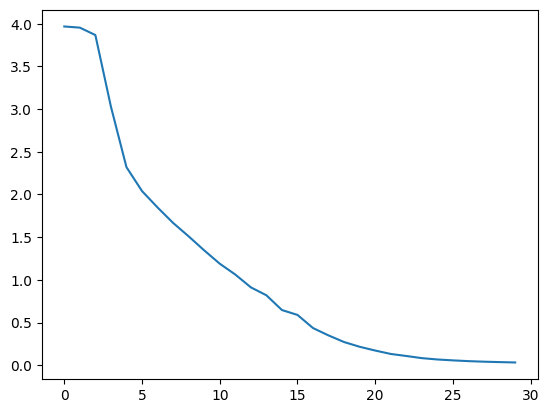

In [28]:
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = myCNN().to(device)
lr = 0.1
num_epochs = 30
ls = []
momentum = 0.5
opt = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
sch = ExponentialLR(opt, 0.9, verbose=True)
for i in range(num_epochs):
    total_loss = 0
    for batch in train_loader:
        x, y = batch[0].to(device), batch[1].to(device)
        yhat = model(x)
        loss = loss_fn(yhat, y)  # Use a different variable name for the loss tensor
        opt.zero_grad()
        loss.backward()
        opt.step()
        total_loss += loss.item()
    ls.append(total_loss / len(train_loader))
    sch.step()

plt.plot(ls)


In [29]:
# ADD CODE HERE
total_correct = 0
total_example=0
for batch in test_loader :
  x,y = batch[0].to(device) ,  batch[1].to(device)
  yhat = model(x)
  prediction = torch.argmax(yhat, axis = 1) #we put sofmax sepreatly becouse 
  correct_prediction= (prediction == y).sum().item()
  total_example += y.size(0)
  total_correct += correct_prediction
accuracy = total_correct/ total_example
print(f"Accuracy on the test set: {accuracy:.2%}")

<ipython-input-5-3b70819f2fc7>:16: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im = iio.imread(f"{self.im_fol}{self.im_list[idx]}")


Accuracy on the test set: 78.49%
